<a href="https://colab.research.google.com/github/VaflyaRaznovkusnaya/NeuralAlgoritm_Lessons_PyTorch/blob/main/Lab3Clothes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Библиотеки
import torch
import torchvision
import matplotlib.pyplot
import numpy
from torch.optim import Adam
from torch.autograd import Variable
from torchvision.datasets import FashionMNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

#Готовим Датасет

transformf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 10
#Что можем распозновать
# Для FASHIONMNIST. FASHIONMNIST содержит базу черно-белых элементов одежды, которые прономерованы от 0 до 9 в лэйблах
Labels_number = 10
tags = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

#Загружаем и оформляем обучающую и тестовую выборки
train_path = FashionMNIST(root="./data",train=True,transform=transformf,download=True)
train_set = DataLoader(train_path, batch_size=batch_size, shuffle=True, num_workers=0)
#print("В обучающей выборке столько картинок : ", len(train_set)*batch_size)
#Будем грузить в главном потоке, поэтому num_workers = 0
test_path = FashionMNIST(root="./data",train=False,transform=transformf,download=True)
test_set = DataLoader(test_path, batch_size=batch_size, shuffle=False, num_workers=0)
#print("В тестовой выборке столько картинок : ", len(test_set)*batch_size)

#Класс нейронки
class Neural(torch.nn.Module):
    def __init__(self):
        super(Neural, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(12)
        self.conv2 = torch.nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(12)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.conv4 = torch.nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = torch.nn.BatchNorm2d(24)
        self.conv5 = torch.nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = torch.nn.BatchNorm2d(24)
        self.fc1 = torch.nn.Linear(24*8*8, 10)

    def forward(self, input):
        output = torch.nn.functional.relu(self.bn1(self.conv1(input)))
        output = torch.nn.functional.relu(self.bn2(self.conv2(output)))
        output = self.pool(output)
        output = torch.nn.functional.relu(self.bn4(self.conv4(output)))
        output = torch.nn.functional.relu(self.bn5(self.conv5(output)))
        output = output.view(-1, 24*8*8)
        output = self.fc1(output)

        return output

SmartKitty = Neural() #Создаём экземпляр нейронки

#Оптимизатор
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = Adam(SmartKitty.parameters(), lr=0.001, weight_decay=0.0001)
#===================================Функции=========================================================
#Обучение
def train(num_epochs):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #print("The model will be running on", device, "device")
    SmartKitty.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_set, 0):

            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            optimizer.zero_grad()
            outputs = SmartKitty(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        #Выводим точность для всей эпохи
        accuracy = testAccuracy()
        print('Эпоха', epoch+1,' закончилась с точностью ', accuracy)

#Проверка точности
def testAccuracy():

    SmartKitty.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in test_set:
            images, labels = data
            outputs = SmartKitty(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    accuracy = (accuracy / total)
    return(accuracy)

#Вызов итогов
def showImages(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    matplotlib.pyplot.imshow(numpy.transpose(npimg, (1, 2, 0)))
    matplotlib.pyplot.show()

def finalTest():
    # use second database (network haven't seen it)
    images, labels = next(iter(test_set))

    showImages(torchvision.utils.make_grid(images))
    print('Реальное значение: ', ' '.join('%5s' % tags[labels[j]]
                               for j in range(batch_size)))

    outputs = SmartKitty(images)
    _, predicted = torch.max(outputs, 1)
    print('Предположительное: ', ' '.join('%5s' % tags[predicted[j]]
                              for j in range(batch_size)))

In [ ]:
train(5)
print('\n Модель закончила обучение')

Эпоха 1  закончилась с точностью  0.8386
Эпоха 2  закончилась с точностью  0.8554
Эпоха 3  закончилась с точностью  0.8627
Эпоха 4  закончилась с точностью  0.8629
Эпоха 5  закончилась с точностью  0.8609

 Модель закончила обучение


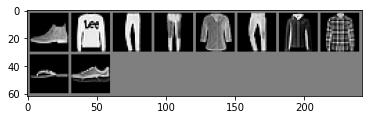

Реальное значение:      9     2     1     1     6     1     4     6     5     7
Предположительное:      9     2     1     1     6     1     6     6     5     7


In [ ]:
finalTest()